In [1]:
import pandas as pd
# pd.set_option("display.float_format", "{:.3f}".format)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay)
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import shap
import seaborn as sns
from IPython.display import display, Markdown, Latex
import random
random.seed(42)
import os
 
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.set_seed(seed)
    random.seed

In [2]:
data = pd.read_csv('/Users/kayadetunji/Downloads/HAALSI_work/project2_data_21_04_23.csv').drop(columns = 
       ['Unnamed: 0','study_id']).fillna(-999)

In [3]:
data.columns

Index(['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc',
       'cadiovascular_current', 'bmi_c_qc', 'age', 'cimt_mean_max',
       'cholesterol_1_qc', 'friedewald_ldl_c_c_qc', 'hdl_qc',
       'triglycerides_qc', 'waist_hip_r_c_qc', 'waist_circumference_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'site', 'sex',
       'hiv_final_status_c', 'highest_level_of_education_qc',
       'partnership_status_c_qc', 'ses_site_quintile_c_qc', 'occupation_qc',
       'mvpa_cat_c', 'alcohol_use_status_c_qc', 'smoking_status_c_qc'],
      dtype='object')

In [4]:
site_id = 1
data = data[(data['site'] == site_id) & (data['age'] <= 65) & (data['age'] >= 40)].copy()

In [5]:
# Simple Function to calcuate CVD
def calculate_CVD(a,b,c,d,e):
    col=0
    if (int(a)==1 or int(b)==1 or int(c)==1 or int(d)==1 or int(e)==1):
        col=1
    elif (int(a)==0 and int(b)==0 and int(c)==0 and int(d)==0 and int(e)==0):
        col = 0
    elif (int(a)==pd.isna and int(b)==pd.isna and int(c)==pd.isna and int(d)==pd.isna and int(e)==pd.isna):
        col = 0
    return col

In [6]:
X = data[['bmi_c_qc', 'age', 'cimt_mean_max',
       'cholesterol_1_qc', 'hdl_qc',
       'triglycerides_qc', 'waist_hip_r_c_qc', 'waist_circumference_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'sex',
       'hiv_final_status_c', 'highest_level_of_education_qc',
       'partnership_status_c_qc', 'ses_site_quintile_c_qc', 'occupation_qc',
       'mvpa_cat_c', 'alcohol_use_status_c_qc', 'smoking_status_c_qc']]
target_col = 'MM'
target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc','cadiovascular_current']
data[target_col] = ((data[target_cols] == 1).sum(axis=1) >= 2).astype(int)

y1 = data.loc[:,target_col]
# y1 = data.loc[:,'htn_jnc7_qc']

In [7]:
y1.value_counts(normalize=True)

0    0.837422
1    0.162578
Name: MM, dtype: float64

In [8]:
data['mvpa_cat_c'].value_counts(normalize=True)

1.0    0.776954
0.0    0.223046
Name: mvpa_cat_c, dtype: float64

In [9]:
dff = data.mask(data == -999, np.nan).copy()

[IterativeImputer] Early stopping criterion not reached.


<Axes: ylabel='Density'>

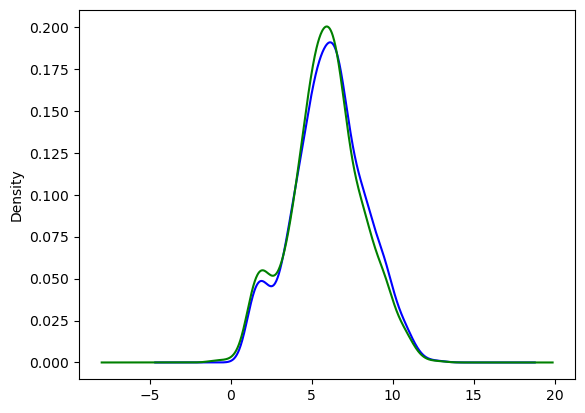

In [10]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff[X.columns])
train_t = imputer.transform(dff[X.columns])
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=X.columns)
# treated = treated.apply(np.ceil)
treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']]\
      = np.round(treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']], decimals=0)

fig = plt.figure()
ax = fig.add_subplot(111)
dff['visceral_fat_qc'].plot(kind='kde', ax=ax, color='blue')
treated['visceral_fat_qc'].plot(kind='kde', ax=ax, color='green')

In [11]:
treated.columns

Index(['bmi_c_qc', 'age', 'cimt_mean_max', 'cholesterol_1_qc', 'hdl_qc',
       'triglycerides_qc', 'waist_hip_r_c_qc', 'waist_circumference_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'sex', 'hiv_final_status_c',
       'highest_level_of_education_qc', 'partnership_status_c_qc',
       'ses_site_quintile_c_qc', 'occupation_qc', 'mvpa_cat_c',
       'alcohol_use_status_c_qc', 'smoking_status_c_qc'],
      dtype='object')

In [12]:
predictors = ['bmi_c_qc', 'age', 'cimt_mean_max',
       'cholesterol_1_qc', 'hdl_qc',
       'triglycerides_qc', 'waist_hip_r_c_qc', 'waist_circumference_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'sex',
       'hiv_final_status_c', 'highest_level_of_education_qc',
       'partnership_status_c_qc', 'ses_site_quintile_c_qc', 'occupation_qc',
       'mvpa_cat_c', 'alcohol_use_status_c_qc', 'smoking_status_c_qc']

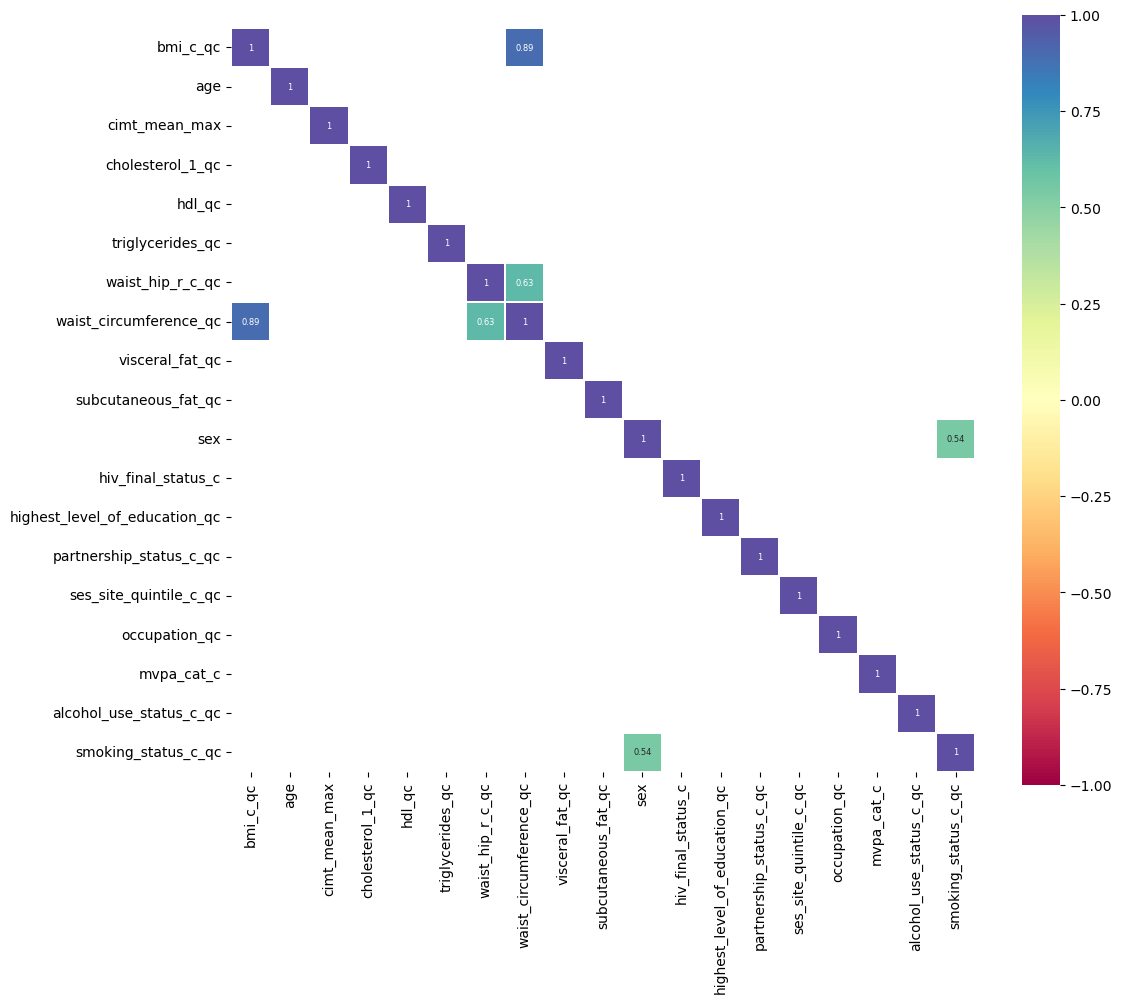

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify correlated variables using correlation coefficients
correlation_matrix = treated.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]


plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix[(correlation_matrix >= 0.5) | (correlation_matrix <= -0.4)], 
            cmap='Spectral', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 6}, square=True);

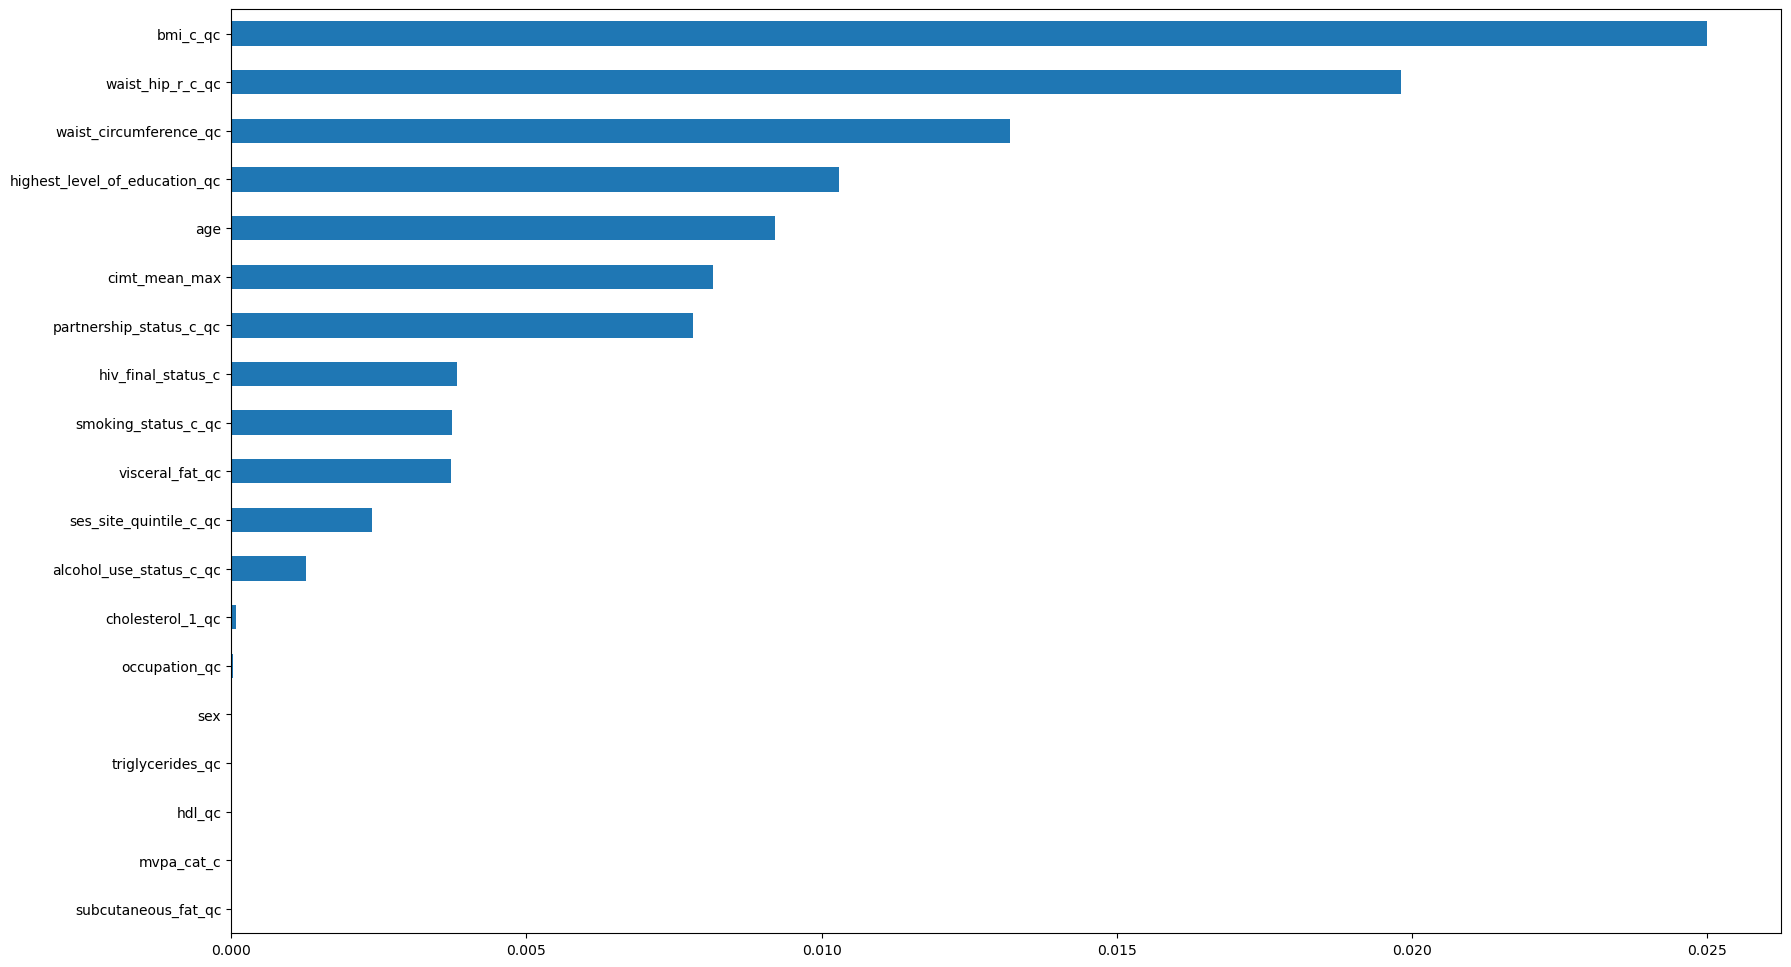

In [14]:
from sklearn.feature_selection import mutual_info_classif
## First, treat missing values before execution
# X = treated.values
X2 = treated[predictors].values
y = y1
importance = mutual_info_classif(X2,y)
# feat_importance = pd.Series(importance, treated.columns[0:len(data.columns)-1])
feat_importance = pd.Series(importance, treated[predictors].columns[0:len(treated[predictors].columns)-0])
ff = feat_importance.sort_values(ascending=True)
plt.figure(figsize=(20,12))
ff.plot(kind='barh')
plt.show()

In [15]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(treated, y1, test_size=0.2, random_state=42, stratify=treated[['sex']])

# Initialize XGBoost classifier
model = xgb.XGBClassifier()

# Define the grid of hyperparameters to search
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='roc_auc', cv=3, verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the model with the best parameters
model.set_params(**best_params)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
predictions = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, predictions)
print(f"The AUC score for the optimized model is: {auc_score}")

Fitting 3 folds for each of 135 candidates, totalling 405 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END cols

In [16]:
y1

361     0
366     0
367     0
371     0
375     0
       ..
4477    1
4478    0
4480    0
4484    0
4485    0
Name: MM, Length: 1753, dtype: int64

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# Load your dataset
# data = pd.read_csv('your_dataset.csv')
# X = data.drop('target_column', axis=1)
# y = data['target_column']

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42, stratify=y1)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5],
    # 'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Initialize the XGBClassifier
xgb_clf = XGBClassifier(eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
                           scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the model with the best parameters
best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
best_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model using AUC
auc_score = roc_auc_score(y_test, predictions)
print(f"The AUC score for the optimized model is: {auc_score}")


Fitting 3 folds for each of 2500 candidates, totalling 7500 fits
[CV] END colsample_bytree=0.6, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.6, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.6, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.6, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] EN

`use_label_encoder` is deprecated in 1.7.0.


In [17]:
best_params

{'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 0.8}

In [18]:
model11 = xgb.XGBClassifier(**best_params, eval_metric='logloss')

model11.fit(X_train, y_train)

Y_pred_proba_mod11 = model11.predict_proba(X_test)[:, 1]
Y_pred_mod11 = model11.predict(X_test)
auc_score1 = roc_auc_score(y_test, Y_pred_proba_mod11)
print(f"The AUC score for the optimized model is: {auc_score1}")


The AUC score for the optimized model is: 0.7107410101849928


In [43]:
best_params1 = {'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 9.98668141e+00,
 'n_estimators': 100,
 'subsample': 1.0,
#  'gamma': 5.99751638e+00,
 'colsample_bytree': 0.8
 }

In [28]:
XGB_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("XGBoost", xgb.XGBClassifier(**best_params))
])

RF_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("RandomForest", RandomForestClassifier())
])

GB_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("RandomForest", GradientBoostingClassifier())
])

LR_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("Logistic_Regression", LogisticRegression(max_iter=10))
])

In [29]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
XGB_pipeline.fit(X_train, y_train,XGBoost__sample_weight=classes_weights)
RF_pipeline.fit(X_train, y_train)
LR_pipeline.fit(X_train, y_train)
GB_pipeline.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Pipeline(steps=[('preprocessing', StandardScaler()),
                ('RandomForest', GradientBoostingClassifier())])

In [30]:
Y_pred_proba_XGB = XGB_pipeline.predict_proba(X_test)[:,1]
Y_pred_XGB = XGB_pipeline.predict(X_test)


Y_pred_proba_RF = RF_pipeline.predict_proba(X_test)[:,1]
Y_pred_RF = RF_pipeline.predict(X_test)

Y_pred_proba_LR = LR_pipeline.predict_proba(X_test)[:,1]
Y_pred_LR = LR_pipeline.predict(X_test)

Y_pred_proba_GB = GB_pipeline.predict_proba(X_test)[:,1]
Y_pred_GB = GB_pipeline.predict(X_test)

In [31]:
print('XGB accuracy', roc_auc_score(y_test, Y_pred_proba_XGB))
print('RF accuracy', roc_auc_score(y_test, Y_pred_proba_RF))
print('LR accuracy', roc_auc_score(y_test, Y_pred_proba_LR))
print('GB accuracy', roc_auc_score(y_test, Y_pred_proba_GB))

XGB accuracy 0.7422053627104552
RF accuracy 0.6957233423404697
LR accuracy 0.7450114321346913
GB accuracy 0.6517875701517356


Text(0, 0.5, 'True Positive rate')

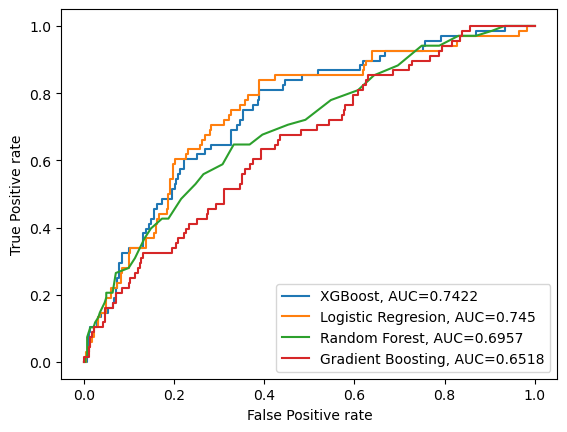

In [118]:
# RocCurveDisplay.from_predictions(test_targets, Y_pred_proba_XGB)
# RocCurveDisplay.from_predictions(test_targets, Y_pred_proba_RF)
# RocCurveDisplay.from_predictions(test_targets, Y_pred_proba_LR)
#set up plotting area

from sklearn import metrics
plt.figure(0).clf()

#fit logistic regression model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, Y_pred_proba_XGB)
auc = round(metrics.roc_auc_score(y_test, Y_pred_proba_XGB), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc))

#fit gradient boosted model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, Y_pred_proba_LR)
auc = round(metrics.roc_auc_score(y_test, Y_pred_proba_LR), 4)
plt.plot(fpr,tpr,label="Logistic Regresion, AUC="+str(auc))

#fit gradient boosted model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, Y_pred_proba_RF)
auc = round(metrics.roc_auc_score(y_test, Y_pred_proba_RF), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#fit gradient boosted model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, Y_pred_proba_GB)
auc = round(metrics.roc_auc_score(y_test, Y_pred_proba_GB), 4)
plt.plot(fpr,tpr,label="Gradient Boosting, AUC="+str(auc))

#add legend
plt.legend()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

Text(0, 0.5, 'False Positive rate')

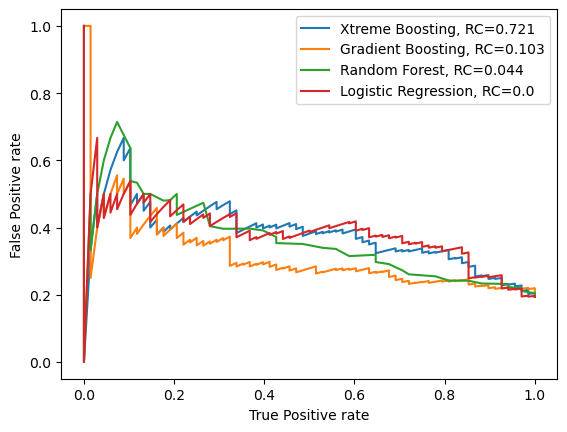

In [120]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
plt.figure(0).clf()
prec, recall, _ = precision_recall_curve(y_test, Y_pred_proba_XGB, pos_label=XGB_pipeline.classes_[1])
RC = round(recall_score(y_test, Y_pred_XGB),3)
plt.plot(recall,prec,label="Xtreme Boosting, RC="+str(RC))
# prec, recall, _ = precision_recall_curve(test_targets_bal, Y_pred_proba_RF, pos_label=RF_pipeline.classes_[1])
# pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
prec, recall, _ = precision_recall_curve(y_test, Y_pred_proba_GB, pos_label=GB_pipeline.classes_[1])
RC = round(recall_score(y_test, Y_pred_GB),3)
plt.plot(recall,prec,label="Gradient Boosting, RC="+str(RC))
prec, recall, _ = precision_recall_curve(y_test, Y_pred_proba_RF, pos_label=RF_pipeline.classes_[1])
# pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
RC = round(recall_score(y_test, Y_pred_RF),3)
plt.plot(recall,prec,label="Random Forest, RC="+str(RC))
prec, recall, _ = precision_recall_curve(y_test, Y_pred_proba_LR, pos_label=LR_pipeline.classes_[1])
# pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
RC = round(recall_score(y_test, Y_pred_LR),3)
plt.plot(recall,prec,label="Logistic Regression, RC="+str(RC))

#add legend
plt.legend()
plt.xlabel("True Positive rate")
plt.ylabel("False Positive rate")

In [123]:
print(classification_report(Y_pred_XGB, y_test))

              precision    recall  f1-score   support

           0       0.65      0.91      0.76       204
           1       0.72      0.33      0.46       147

    accuracy                           0.67       351
   macro avg       0.69      0.62      0.61       351
weighted avg       0.68      0.67      0.63       351



In [126]:
print(classification_report(y_test, Y_pred_XGB))

              precision    recall  f1-score   support

           0       0.91      0.65      0.76       283
           1       0.33      0.72      0.46        68

    accuracy                           0.67       351
   macro avg       0.62      0.69      0.61       351
weighted avg       0.80      0.67      0.70       351



In [147]:
balanced_accuracy_score(y_test, Y_pred_XGB)

0.6871492413219704

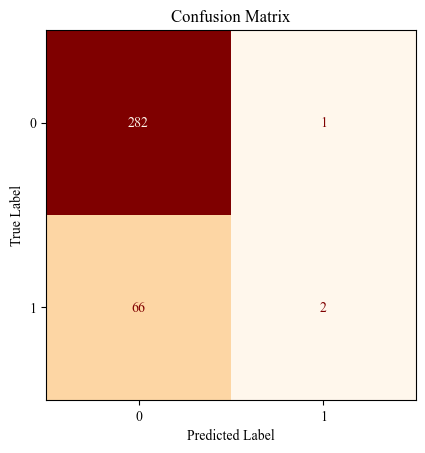

In [141]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Assume model is already defined and trained
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with custom colors
fig, ax = plt.subplots()
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(ax=ax, cmap='OrRd', colorbar=False)  # Use a different colormap

# Customize the plot (optional)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.gca().images[-1].colorbar.set_label('Number of Predictions')
plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Times New Roman']})
plt.show()

In [128]:
y_test.value_counts()

0    283
1     68
Name: MM, dtype: int64

In [34]:
# SHAP Modelling
shap.initjs()
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

In [35]:
# SHAP Analysis

explainer1 = shap.TreeExplainer(model, X_test)
shap_values1 = explainer1(X_test)

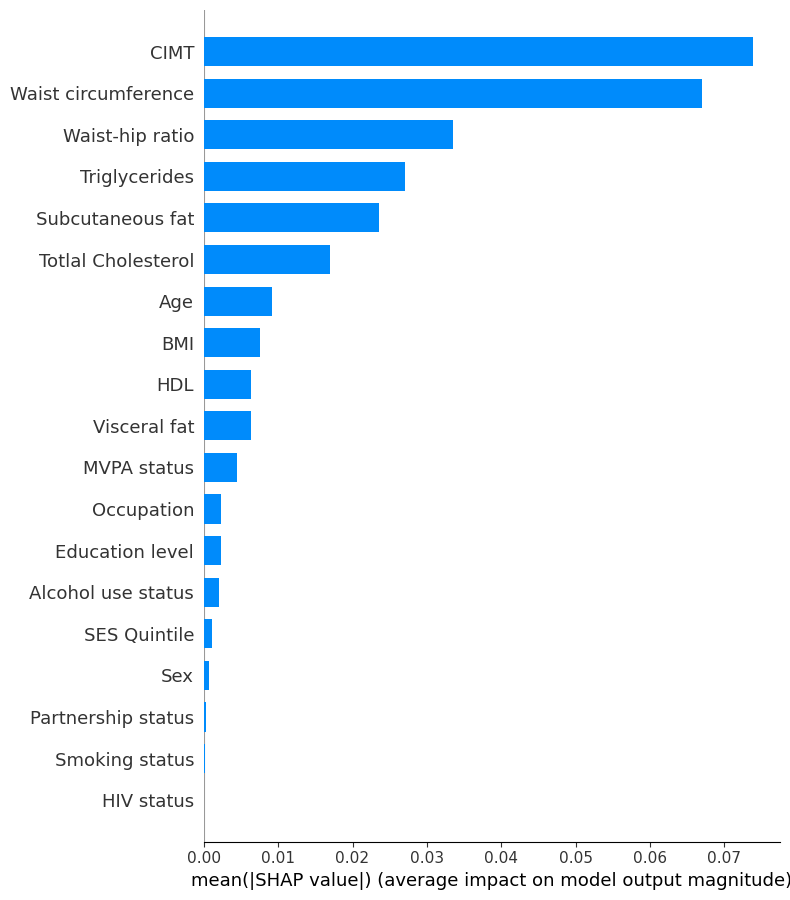

In [36]:
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = ['BMI', 'Age', 'CIMT', 'Totlal Cholesterol', 'HDL',
       'Triglycerides', 'Waist-hip ratio', 'Waist circumference',
       'Visceral fat', 'Subcutaneous fat', 'Sex', 'HIV status',
       'Education level', 'Partnership status',
       'SES Quintile', 'Occupation', 'MVPA status',
       'Alcohol use status', 'Smoking status'] )

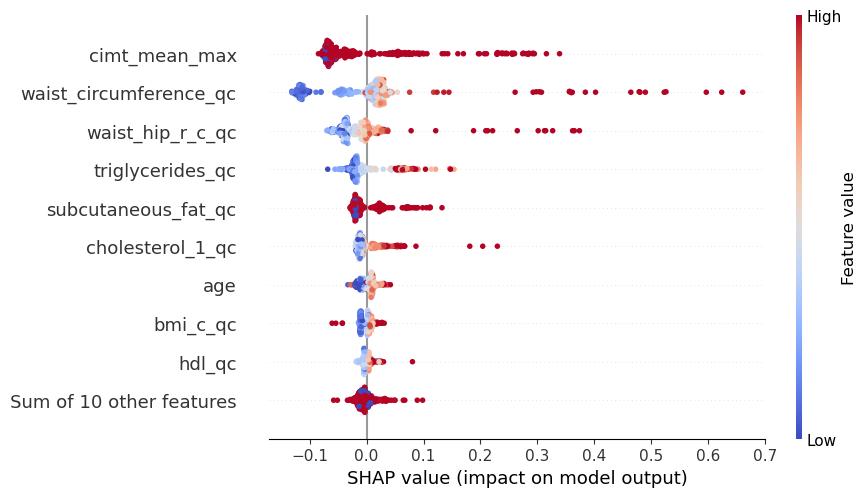

In [38]:
shap.plots.beeswarm(shap_values, color=plt.get_cmap("coolwarm"), max_display=10)

In [39]:
shap_values2 = shap.TreeExplainer(model).shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


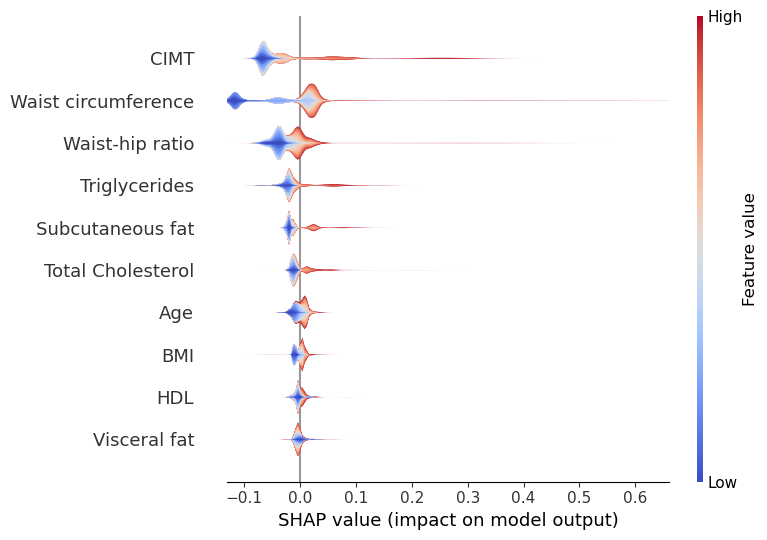

In [40]:
shap.summary_plot(shap_values[:,:], X_test.iloc[:,:], feature_names = ['BMI', 'Age', 'CIMT', 'Total Cholesterol', 'HDL',
       'Triglycerides', 'Waist-hip ratio', 'Waist circumference',
       'Visceral fat', 'Subcutaneous fat', 'Sex', 'HIV status',
       'Education level', 'Partnership status',
       'SES Quintile', 'Occupation', 'MVPA status',
       'Alcohol use status', 'Smoking status'], plot_type = 'layered_violin', color='coolwarm', max_display=10)

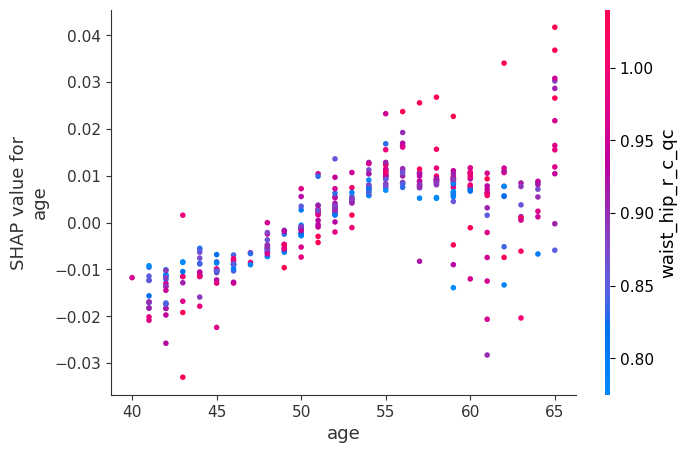

In [41]:
shap.dependence_plot("age", shap_values.values, X_test, color=plt.get_cmap("coolwarm"))

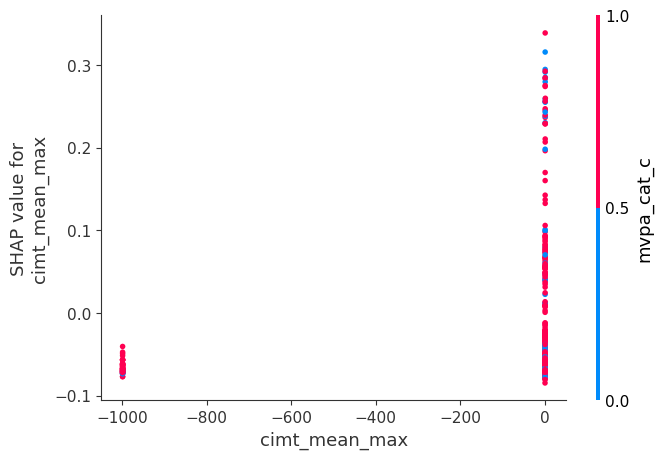

In [121]:
shap.dependence_plot("cimt_mean_max", shap_values.values, X_test)

In [43]:
(Y_pred_XGB)

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,

In [103]:
explainer5 = shap.TreeExplainer(model)
shap_values5 = explainer5.shap_values(X_test)
# shap.initjs()
def local_explainer(j):
    return(shap.force_plot(explainer.expected_value, shap_values5[j,:], X_test.iloc[j,:]))
def local_explainer_logit(j):
    return(shap.force_plot(explainer.expected_value, shap_values5[j,:], X_test.iloc[j,:], link='logit', plot_cmap='PkYg'))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [104]:
# Non-CVD case
local_explainer_logit(7)

In [105]:
local_explainer_logit(6)

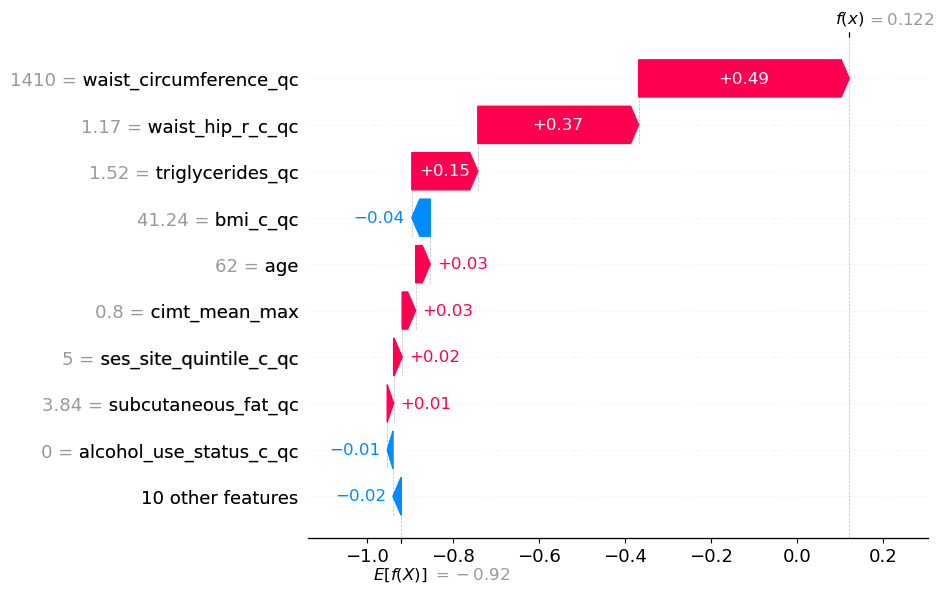

In [49]:
shap.plots.waterfall(shap_values[6])

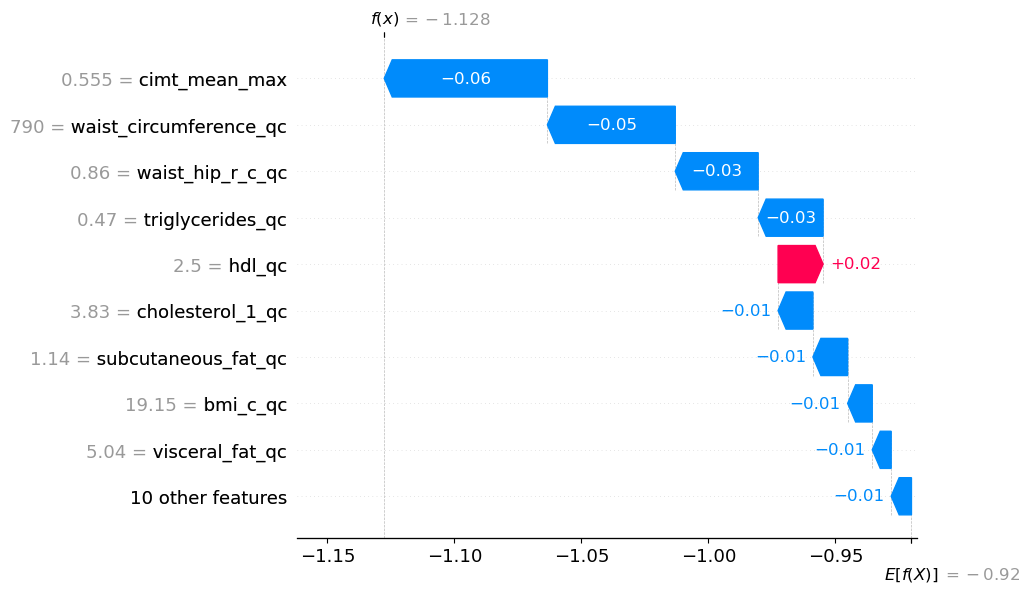

In [54]:
shap.plots.waterfall(shap_values[7])

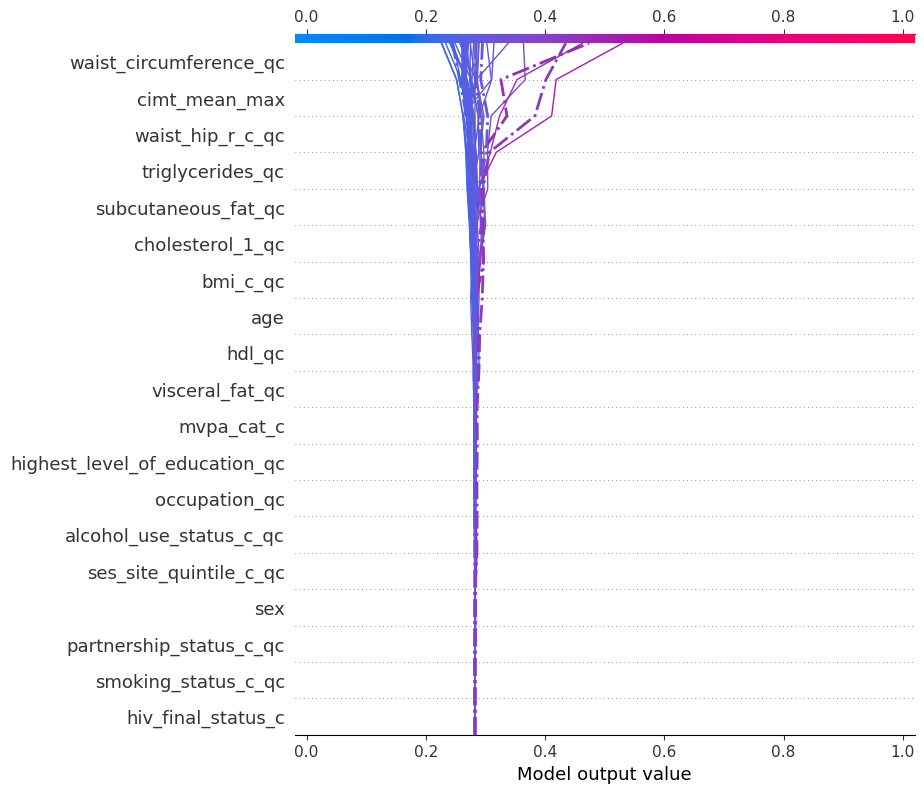

In [106]:
# Our naive cutoff point is zero log odds (probability 0.5).
select = range(40)
y_pred = (shap_values5.sum(1) + explainer5.expected_value) > 0
targets = y_test.reset_index()
misclassified = y_pred[select] != targets.iloc[select,1]
shap.decision_plot(explainer5.expected_value, shap_values5[select], X_test.columns, link='logit', highlight=misclassified)

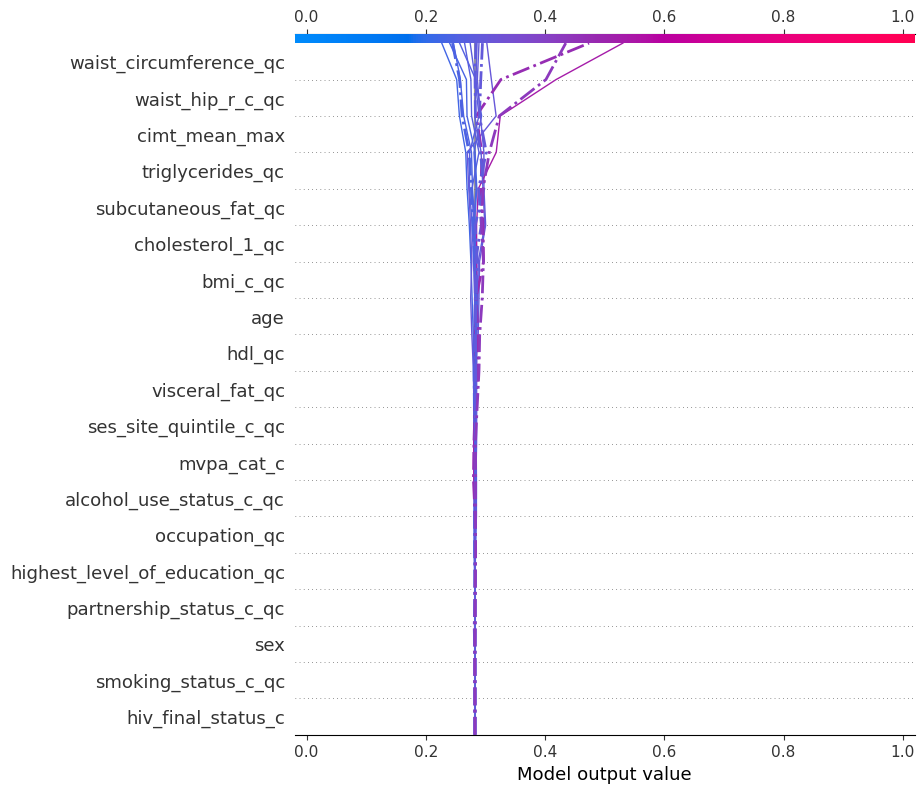

In [117]:
# Identify misclassified instances
y_pred = (shap_values5.sum(1) + explainer5.expected_value) > 0
targets = y_test.reset_index()
misclassified_indices = [i for i in range(len(y_pred)) if y_pred[i] != targets.iloc[i, 1]]
correctly_classified_indices = [i for i in range(len(y_pred)) if y_pred[i] == targets.iloc[i, 1]]

# Select 10 correctly classified and 5 misclassified
selected_correct_indices = correctly_classified_indices[:10]
selected_misclassified_indices = misclassified_indices[:5]
selected_indices = selected_correct_indices + selected_misclassified_indices

# Filter SHAP values and features for selected instances
shap_values_selected = shap_values5[selected_indices]
X_selected = X_test.iloc[selected_indices]

# Highlight misclassified in the selected indices
highlight_indices = list(range(10, 15))

# Plot the decision plot for selected instances
shap.decision_plot(explainer5.expected_value, shap_values_selected, X_selected.columns, link='logit', highlight=highlight_indices)

In [56]:
pred = ['bmi_c_qc', 'age','cholesterol_1_qc', 'hdl_qc', 'waist_hip_r_c_qc', 'sex', 
        'hiv_final_status_c', 'highest_level_of_education_qc', 'partnership_status_c_qc',
       'ses_site_quintile_c_qc', 'occupation_qc', 'mvpa_cat_c',
       'alcohol_use_status_c_qc', 'smoking_status_c_qc']

In [55]:
feature_names = ['BMI', 'Age', 'CIMT', 'Totlal Cholesterol', 'HDL',
       'Triglycerides', 'Waist-hip ratio', 'Waist circumference',
       'Visceral fat', 'Subcutaneous fat', 'Sex', 'HIV status',
       'Education level', 'Partnership status',
       'SES Quintile', 'Occupation', 'MVPA status',
       'Alcohol use status', 'Smoking status']

In [69]:
X_test1.shape

(351, 14)

In [85]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

# Split the dataset into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(treated[pred], y1, test_size=0.2, random_state=42, stratify=treated[['sex']])

# Initialize XGBoost classifier
model1 = xgb.XGBClassifier()

# Define the grid of hyperparameters to search
param_grid1 = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01],
    'n_estimators': [90,100, 200, 300],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Set up the grid search with cross-validation
grid_search1 = GridSearchCV(estimator=model1, param_grid=param_grid1, 
                           scoring='roc_auc', cv=3, verbose=2)

# Perform grid search
grid_search1.fit(X_train1, y_train1)

# Retrieve the best parameters
best_params1 = grid_search1.best_params_
print(f"Best parameters found: {best_params1}")

# Train the model with the best parameters
model1.set_params(**best_params1)
model1.fit(X_train1, y_train1)

# Make predictions and evaluate the model
predictions1 = model1.predict_proba(X_test1)[:, 1]
auc_score1 = roc_auc_score(y_test1, predictions1)
print(f"The AUC score for the optimized model is: {auc_score1}")

Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=90, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=90, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=90, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=90, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=90, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=90, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=90, subsample=1; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=90, subsample=1; total time=   0.0s
[CV] END colsample_by

In [88]:
model1 = xgb.XGBClassifier(**best_params)
model1.fit(X_train1, y_train1)

# Make predictions and evaluate the model
predictions1 = model1.predict_proba(X_test1)[:, 1]
auc_score1 = roc_auc_score(y_test1, predictions1)
print(f"The AUC score for the optimized model is: {auc_score1}")

The AUC score for the optimized model is: 0.7062720848056537


In [91]:
explainer_res = shap.Explainer(model1, X_test1)
shap_values_res = explainer_res(X_test1)

In [89]:
explainer11 = shap.TreeExplainer(model1, X_test1)
shap_values1 = explainer11(X_test1)

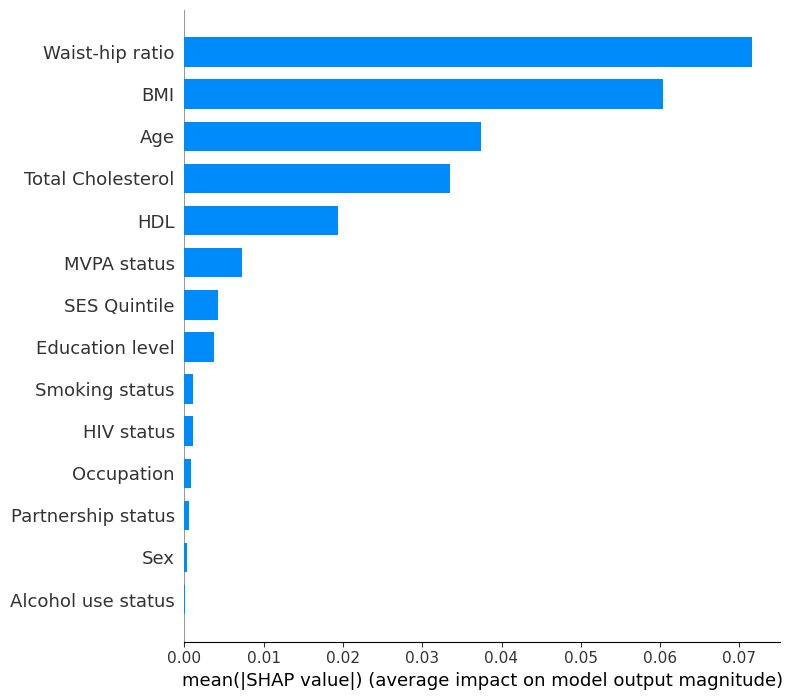

In [92]:
shap.summary_plot(shap_values_res, plot_type = 'bar', feature_names = ['BMI', 'Age', 'Total Cholesterol', 'HDL',
       'Waist-hip ratio', 'Sex', 'HIV status',
       'Education level', 'Partnership status',
       'SES Quintile', 'Occupation', 'MVPA status',
       'Alcohol use status', 'Smoking status'] )

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


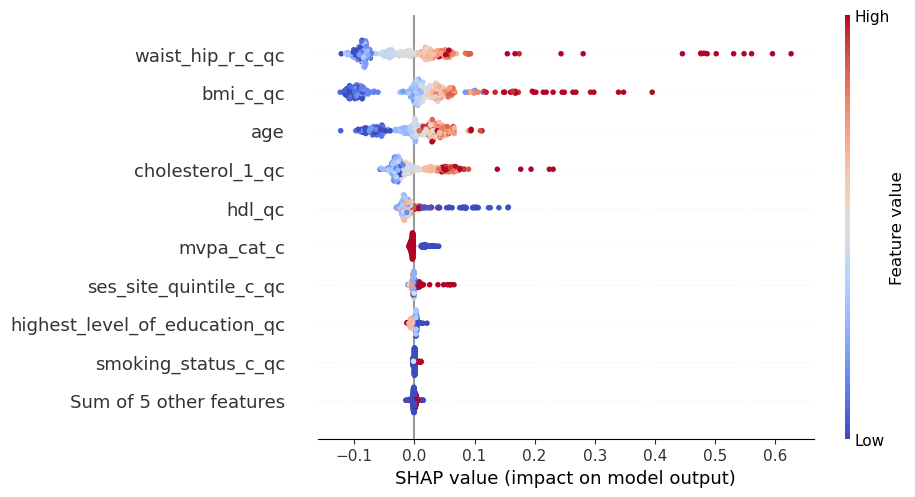

In [93]:
shap.plots.beeswarm(shap_values_res, color=plt.get_cmap("coolwarm"), max_display=10)

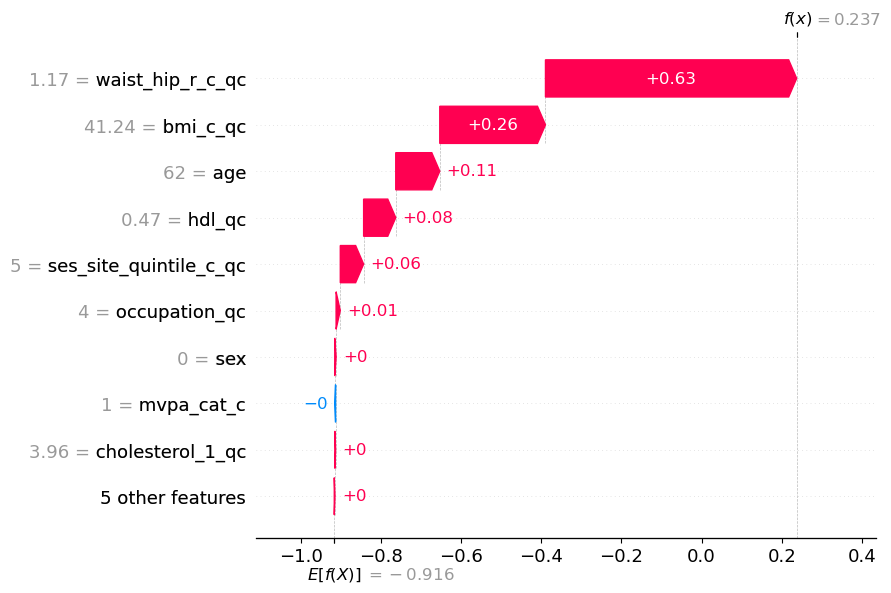

In [94]:
shap.plots.waterfall(shap_values_res[6])

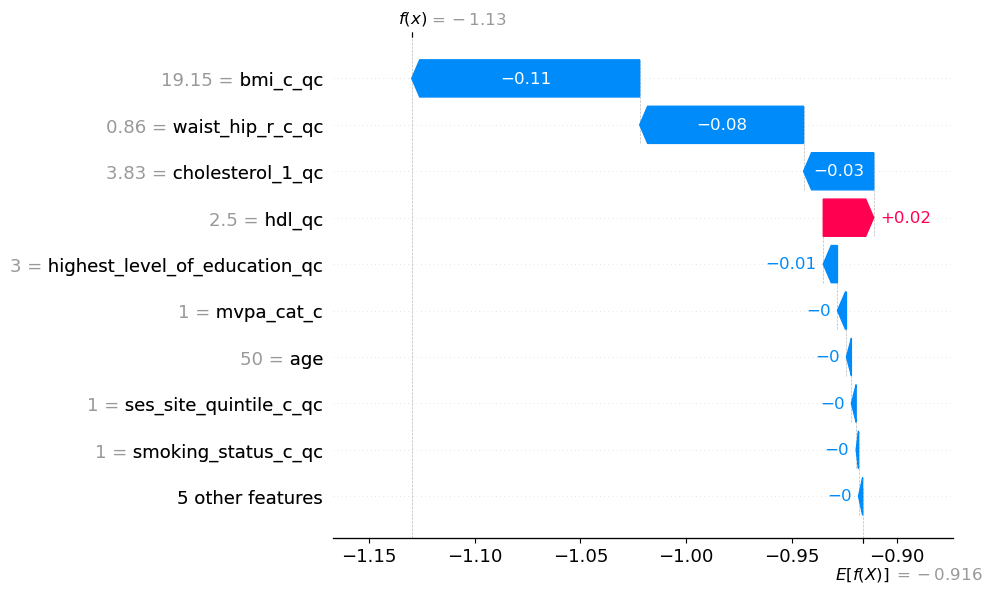

In [110]:
shap.plots.waterfall(shap_values_res[7])

In [111]:
shap.plots.force(shap_values_res[7], plot_cmap='PkYg', link='logit')

In [112]:
shap.plots.force(shap_values_res[6], plot_cmap='PkYg', link='logit')

In [ ]:
# Identify misclassified instances
y_pred = (shap_values_res.sum(1) + explainer5.expected_value) > 0
targets1 = y_test1.reset_index()
misclassified_indices = [i for i in range(len(y_pred)) if y_pred[i] != targets1.iloc[i, 1]]
correctly_classified_indices = [i for i in range(len(y_pred)) if y_pred[i] == targets1.iloc[i, 1]]

# Select 10 correctly classified and 5 misclassified
selected_correct_indices = correctly_classified_indices[:10]
selected_misclassified_indices = misclassified_indices[:5]
selected_indices = selected_correct_indices + selected_misclassified_indices

# Filter SHAP values and features for selected instances
shap_values_selected = shap_values_res[selected_indices]
X_selected = X_test.iloc[selected_indices]

# Highlight misclassified in the selected indices
highlight_indices = list(range(10, 15))

# Plot the decision plot for selected instances
shap.decision_plot(explainer5.expected_value, shap_values_selected, X_selected.columns, link='logit', highlight=highlight_indices)

In [142]:
!pip install streamlit shap scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 12.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 13.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 15.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.15.8
    Uninstalling protobuf-3.15.8:
      Successfully uninstalled protobuf-3.15.8
ERROR: pip's dependency resolver does not currently take into account all the package

In [144]:
import streamlit as st
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

# Load dataset and train a model
iris = load_iris()
X, y = iris.data, iris.target
feature_names = iris.feature_names
model = RandomForestClassifier().fit(X, y)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Function to make prediction and SHAP values
def predict_and_explain(data):
    prediction = model.predict(data)
    shap_values = explainer.shap_values(data)
    return prediction, shap_values

# Streamlit app
st.title("Human-Machine Interface for AI - Counterfactual Analysis")

st.sidebar.header("Input Features")
selected_feature = st.sidebar.selectbox("Select Feature to Change:", feature_names)
new_value = st.sidebar.slider("Enter New Value for the Feature:", float(X[:, feature_names.index(selected_feature)].min()), float(X[:, feature_names.index(selected_feature)].max()), float(X[:, feature_names.index(selected_feature)].mean()))

st.sidebar.header("Control Buttons")
if st.sidebar.button("Update Prediction"):
    modified_data = X.copy()
    modified_data[0, feature_names.index(selected_feature)] = new_value

    prediction, shap_values_cf = predict_and_explain(modified_data[0].reshape(1, -1))

    st.write(f"Original Prediction: {model.predict(X[0].reshape(1, -1))}")
    st.write(f"Counterfactual Prediction: {prediction}")

    st.subheader("SHAP Values (Original)")
    shap.initjs()
    st_shap(shap.force_plot(explainer.expected_value[1], shap_values[1][0], X[0], feature_names=feature_names))

    st.subheader("SHAP Values (Counterfactual)")
    st_shap(shap.force_plot(explainer.expected_value[1], shap_values_cf[1][0], modified_data[0], feature_names=feature_names))
else:
    st.write("Adjust the feature value and press 'Update Prediction' to see the changes.")

# Function to render the SHAP plot in Streamlit
def st_shap(plot, height=None):
    shap_html = f"<head>{shap.getjs()}</head><body>{plot.html()}</body>"
    st.components.v1.html(shap_html, height=height)

# Plot original SHAP values
st.header("Original SHAP Values for First Instance")
st_shap(shap.force_plot(explainer.expected_value[1], shap_values[1][0], X[0], feature_names=feature_names))


TypeError: bases must be types